## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

2023-04-17 11:25:53.622489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 11:25:54.970550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import the dataset

In [2]:
df_train = pd.read_csv('train.csv',sep=',')
df_train.text=df_train.text.astype(str)
df_val = pd.read_csv('test.csv',sep=',')
df_val.text=df_val.text.astype(str)

## Data Pre-processing

In [3]:
df = pd.concat([df_train.assign(index="train"),df_val.assign(index="validation")])


In [4]:
df

,textID,text,selected_text,sentiment,index
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,train
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,train
2,088c60f138,my boss is bullying me...,bullying me,negative,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,train
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,train
...,...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",NaN,negative,validation
3530,416863ce47,All alone in this old house again. Thanks for...,NaN,positive,validation
3531,6332da480c,I know what you mean. My little dog is sinkin...,NaN,negative,validation
3532,df1baec676,_sutra what is your next youtube video gonna b...,NaN,positive,validation


In [5]:
# 1 for positive, 0 for negative, None for neutral
df['sentiment_val'] = df['sentiment'].apply(
    lambda x: 1 if x == 'positive' else 0 if x == 'negative' else 3
)

In [6]:
# remove text with sentiment as neutral
df = df[df['sentiment_val'] != 3]
    

In [7]:
df

,textID,text,selected_text,sentiment,index,sentiment_val
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,train,0
2,088c60f138,my boss is bullying me...,bullying me,negative,train,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,train,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,train,0
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,train,1
...,...,...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",NaN,negative,validation,0
3530,416863ce47,All alone in this old house again. Thanks for...,NaN,positive,validation,1
3531,6332da480c,I know what you mean. My little dog is sinkin...,NaN,negative,validation,0
3532,df1baec676,_sutra what is your next youtube video gonna b...,NaN,positive,validation,1


In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
# Convert the "text" column in the DataFrame to string data type
df["text"] = df["text"].astype(str)

# Apply lemmatization to the "text" column using SpaCy library
df["text"] = df['text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))

# Convert all characters in the "text" column to lowercase
df['text'] = df['text'].apply(lambda x: x.lower())

# Remove all non-word and non-space characters from the "text" column using regular expression
df['text'] = df['text'].apply((lambda x: re.sub('[^\w\s]','',x)))


In [10]:
# Define the maximum number of features to keep in the tokenizer
max_features = 3000

# Initialize a tokenizer with the specified number of words to keep
tokenizer = Tokenizer(num_words=max_features, split=' ')

# Fit the tokenizer on the "text" column values in the DataFrame
tokenizer.fit_on_texts(df['text'].values)

In [11]:
# Filter the DataFrame to create separate training and validation DataFrames
df_train = df[df["index"].eq("train")]
df_val = df[df["index"].eq("validation")]

In [12]:
# Convert the text data in the "text" column of df_train DataFrame into sequences of integers
X_train = tokenizer.texts_to_sequences(df_train['text'].values)

# Pad the sequences to ensure they all have the same length
X_train = pad_sequences(X_train)

# Convert the text data in the "text" column of df_val DataFrame into sequences of integers
X_val = tokenizer.texts_to_sequences(df_val['text'].values)

# Pad the sequences to ensure they all have the same length
X_val = pad_sequences(X_val)

In [13]:
[X_train.shape,X_val.shape]

[(16363, 20), (2104, 18)]

In [14]:
# Pad the sequences in X_val with zeros to match the length of sequences in X_train
X_val = np.lib.pad(X_val, ((0,0),(X_train.shape[1] - X_val.shape[1],0)), 'constant', constant_values=(0))

# Check the shape of X_val after padding
print(X_val.shape)

(2104, 20)

In [15]:
# Convert the sentiment labels in df_train and df_val to one-hot encoded vectors
Y_train = np.array(pd.get_dummies((df_train['sentiment']).values))
Y_val = np.array(pd.get_dummies((df_val['sentiment']).values))

## Model Building

In [16]:
# Set the maximum number of features (words) to consider in the embedding
max_features = 3000

# Set the embedding dimension
embed_dim = 128

# Create a sequential model
model = Sequential()

# Add an embedding layer to the model
# The embedding layer converts the input sequence of word indices into dense vectors of fixed size
# The max_features parameter specifies the size of the vocabulary (i.e., the maximum number of words to consider)
# The embed_dim parameter specifies the size of the output embedding vectors
# The input_length parameter specifies the length of the input sequences (i.e., the number of words in each input sequence)
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))

In [17]:
model.add(SpatialDropout1D(0.3))

In [18]:
lstm_out = 256
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))

In [19]:
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 128)           384000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 778,754
Trainable params: 778,754
Non-trainable params: 0
_________________________________________________________________
None


## Model Training

In [20]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2, shuffle=False)

Epoch 1/20
512/512 - 34s - loss: 0.4037 - accuracy: 0.8076 - 34s/epoch - 67ms/step
Epoch 2/20
512/512 - 36s - loss: 0.2845 - accuracy: 0.8812 - 36s/epoch - 70ms/step
Epoch 3/20
512/512 - 39s - loss: 0.2535 - accuracy: 0.8957 - 39s/epoch - 76ms/step
Epoch 4/20
512/512 - 39s - loss: 0.2300 - accuracy: 0.9083 - 39s/epoch - 77ms/step
Epoch 5/20
512/512 - 26s - loss: 0.2089 - accuracy: 0.9162 - 26s/epoch - 51ms/step
Epoch 6/20
512/512 - 32s - loss: 0.1938 - accuracy: 0.9231 - 32s/epoch - 63ms/step
Epoch 7/20
512/512 - 31s - loss: 0.1793 - accuracy: 0.9300 - 31s/epoch - 61ms/step
Epoch 8/20
512/512 - 36s - loss: 0.1653 - accuracy: 0.9337 - 36s/epoch - 70ms/step
Epoch 9/20
512/512 - 35s - loss: 0.1533 - accuracy: 0.9389 - 35s/epoch - 67ms/step
Epoch 10/20
512/512 - 35s - loss: 0.1386 - accuracy: 0.9461 - 35s/epoch - 68ms/step
Epoch 11/20
512/512 - 38s - loss: 0.1349 - accuracy: 0.9451 - 38s/epoch - 74ms/step
Epoch 12/20
512/512 - 38s - loss: 0.1224 - accuracy: 0.9508 - 38s/epoch - 74ms/step
E

## Model Testing

In [21]:
def evaluate_lstm(model, X_test, Y_test):
    # Initialize counters for positive and negative samples and correct predictions
    pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
    # Create an empty list to store the predicted labels
    results = []
    
    # Iterate through each sample in X_test
    for x in range(len(X_test)):
        # Make a prediction using the trained LSTM model
        result = model.predict(X_test[x].reshape(1, X_test.shape[1]),
                               batch_size=1, verbose=3)[0]
        # Compare the predicted label with the true label to update counts of correct predictions
        if np.argmax(result) == np.argmax(Y_test[x]):
            if np.argmax(Y_test[x]) == 0:
                neg_correct += 1
            else:
                pos_correct += 1

        # Update counts of positive and negative samples
        if np.argmax(Y_test[x]) == 0:
            neg_cnt += 1
        else:
            pos_cnt += 1
        # Append the predicted label to the results list
        results.append(np.argmax(result))

    # Convert true labels to a column vector and convert results to a NumPy array and reshape it
    Y_test_argmax = np.argmax(Y_test, axis=1)
    Y_test_argmax = Y_test_argmax.reshape(-1, 1)
    results = np.asarray(results)
    results = results.reshape(-1, 1)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(Y_test_argmax, results)
    # Create a heatmap of the confusion matrix using Seaborn
    fig = plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='GnBu')
    plt.title("Confusion Matrix")
    plt.ylabel('Correct Class')
    plt.xlabel('Predicted class')

    # Calculate accuracy and F1 score
    accuracy = (pos_correct + neg_correct) / (pos_cnt + neg_cnt)
    f1 = 2 * (pos_correct) / (2 * pos_correct + pos_cnt - pos_correct + neg_cnt - neg_correct)

    # Return accuracy, F1 score, and the confusion matrix figure
    return accuracy, f1, fig

Accuracy: 0.861
F1 Score: 0.869


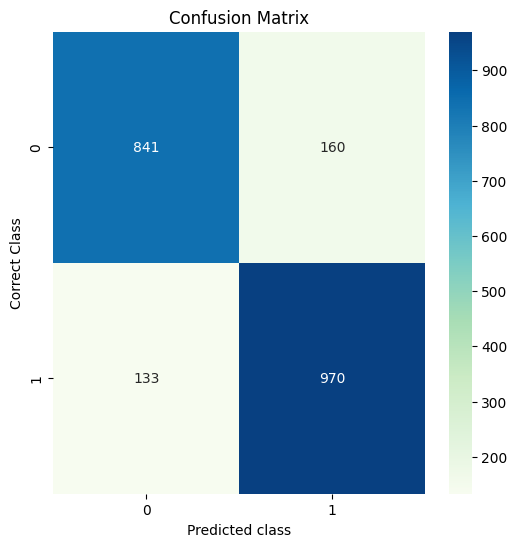

In [22]:
# Call the function with the model, X_val, and Y_val, and print the results
accuracy, f1, fig = evaluate_lstm(model, X_val, Y_val)
print(f'Accuracy: {accuracy:.3f}')
print(f'F1 Score: {f1:.3f}')